In [1]:
#This notebook should only require
   ###Machine learning framework, cpu only
#conda install pytorch torchvision cpuonly -c pytorch
   ###Plotting/visualization library, for displaying MNIST images
#conda install matplotlib

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
n_epochs = 5
batch_size = 64
learning_rate = 0.01
momentum = 0.5
model_dimension = 4

#This notebook is set up to run without GPU-support
torch.backends.cudnn.enabled = False

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self, m_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, m_dim)
        self.fc2 = nn.Linear(m_dim, m_dim)
        self.fc3 = nn.Linear(m_dim, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
network = Net(model_dimension)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [5]:
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()


In [6]:
def test(epoch):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set, {:.0f} epochs: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    epoch, test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [7]:
def debug(n = 0):
  network.eval()
  with torch.no_grad():
    for ix,(data, target) in enumerate(test_loader):
      output = network(data)
      pred = output.data.max(1, keepdim=False)[1]
      if ix == n: break
  fig = plt.figure()
  for i in range(5*5):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.imshow(data[i][0], cmap='gray', interpolation='none')
    plt.title("NN:{}, Data:{}".format(pred[i], target[i]))
    plt.xticks([])
    plt.yticks([])
  fig

C:\Users\akeid\AppData\Local\miniconda3\envs\tekmus\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set, 0 epochs: Avg. loss: 2.3466, Accuracy: 1037/10000 (10%)


Test set, 1 epochs: Avg. loss: 0.8961, Accuracy: 7380/10000 (74%)


Test set, 2 epochs: Avg. loss: 0.5857, Accuracy: 8350/10000 (84%)


Test set, 3 epochs: Avg. loss: 0.5544, Accuracy: 8416/10000 (84%)


Test set, 4 epochs: Avg. loss: 0.5402, Accuracy: 8414/10000 (84%)


Test set, 5 epochs: Avg. loss: 0.5087, Accuracy: 8522/10000 (85%)



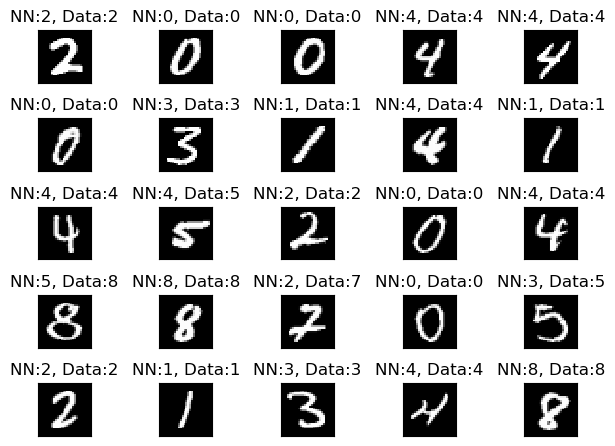

In [8]:
for i in range(n_epochs):
    if i == 0: test(i)
    train()
    test(i+1)
debug()

In [36]:
#ConvNet
#Running this block will "overwrite" the FCNN network defined earlier: you can re-run the training loop to test this network.
class Net(nn.Module):
    def __init__(self, m_dim):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

network = Net(model_dimension)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)